<a href="https://colab.research.google.com/github/tienthinh19/stroke/blob/main/h%C3%BAt_thu%E1%BB%91c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

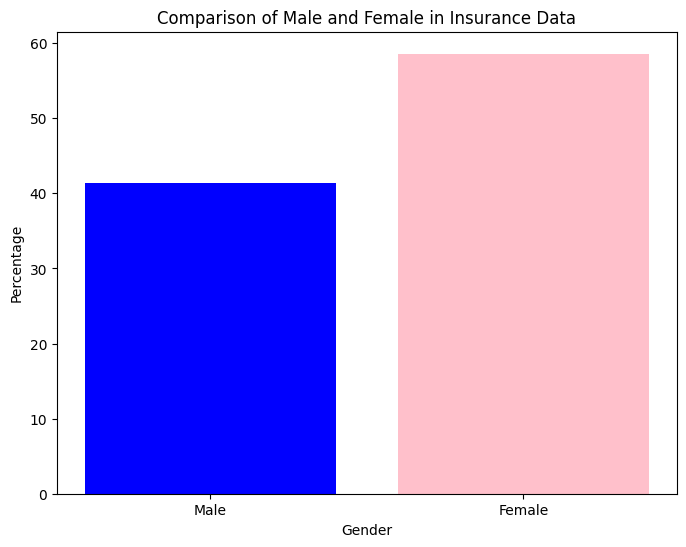

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file CSV
data = pd.read_csv('insurance.csv')

# Lọc nhiễu thuộc tính 'age' là số nguyên và lớn hơn 18
filtered_data = data[(data['age'] > 0) ]
filtered_data = filtered_data.dropna(subset=['bmi'])

# Tính tỷ lệ phần trăm của giới tính 'male' và 'female'
male_percentage = (filtered_data['sex'] == 'Male').mean() * 100
female_percentage = (filtered_data['sex'] == 'Female').mean() * 100

# In ra biểu đồ so sánh
plt.figure(figsize=(8, 6))
plt.bar(['Male', 'Female'], [male_percentage, female_percentage], color=['blue', 'pink'])
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.title('Comparison of Male and Female in Insurance Data')
plt.show()


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
# Data
data = pd.read_csv('insurance.csv')

# Create DataFrame
df = pd.DataFrame(data)

# Apply K-Means clustering
kmeans_age = KMeans(n_clusters=3, random_state=42)
kmeans_bmi = KMeans(n_clusters=3, random_state=42)

# Fit the model
df['age_cluster'] = kmeans_age.fit_predict(df[['age']])
df['bmi_cluster'] = kmeans_bmi.fit_predict(df[['bmi']])

# Display the clustered data
df


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,age,sex,bmi,children,smoker,region,heart_disease,stroke,age_cluster,bmi_cluster
0,67.0,Male,27.900,0,yes,Urban,1,1,0,0
1,61.0,Female,33.770,1,no,Rural,0,1,0,0
2,80.0,Male,33.000,3,no,Rural,1,1,0,0
3,49.0,Female,22.705,0,no,Urban,0,1,2,2
4,79.0,Female,28.880,0,no,Rural,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
10215,80.0,Female,30.780,0,no,Urban,0,0,0,0
10216,81.0,Female,32.300,3,no,Urban,0,0,0,0
10217,35.0,Female,35.530,0,yes,Rural,0,0,2,1
10218,51.0,Male,23.750,4,no,Rural,0,0,2,2


In [ ]:
# Tính tỷ lệ phần trăm của BMI dưới 30
bmi_below_30 = (data['bmi'] < 30).mean() * 100

# Tính tỷ lệ phần trăm của BMI từ 30 đến 40
bmi_30_to_40 = ((data['bmi'] >= 30) & (data['bmi'] < 40)).mean() * 100

# Tính tỷ lệ phần trăm của BMI lớn hơn 40
bmi_over_40 = (data['bmi'] >= 40).mean() * 100

# In tỷ lệ phần trăm
print("Tỷ lệ phần trăm của BMI dưới 30: {:.2f}%".format(bmi_below_30))
print("Tỷ lệ phần trăm của BMI từ 30 đến 40: {:.2f}%".format(bmi_30_to_40))
print("Tỷ lệ phần trăm của BMI lớn hơn 40: {:.2f}%".format(bmi_over_40))



Tỷ lệ phần trăm của BMI dưới 30: 47.32%
Tỷ lệ phần trăm của BMI từ 30 đến 40: 45.81%
Tỷ lệ phần trăm của BMI lớn hơn 40: 6.87%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Đọc dữ liệu từ file CSV
data = pd.read_csv('insurance.csv')

# Tính tổng số mẫu
total_samples = data.shape[0]

# Lọc các mẫu có giá trị 'age' dưới 30
age_under_30 = data[data['age'] < 30]
percent_age_under_30 = (age_under_30.shape[0] / total_samples) * 100

# Lọc các mẫu có giá trị 'age' từ 30 đến 50
age_30_to_50 = data[(data['age'] >= 30) & (data['age'] <= 50)]
percent_age_30_to_50 = (age_30_to_50.shape[0] / total_samples) * 100

# Lọc các mẫu có giá trị 'age' trên 50
age_over_50 = data[data['age'] > 50]
percent_age_over_50 = (age_over_50.shape[0] / total_samples) * 100

# In kết quả
print("Tỷ lệ phần trăm của các mẫu có giá trị 'age' dưới 30: {:.2f}%".format(percent_age_under_30))
print("Tỷ lệ phần trăm của các mẫu có giá trị 'age' từ 30 đến 50: {:.2f}%".format(percent_age_30_to_50))
print("Tỷ lệ phần trăm của các mẫu có giá trị 'age' trên 50: {:.2f}%".format(percent_age_over_50))


Tỷ lệ phần trăm của các mẫu có giá trị 'age' dưới 30: 29.65%
Tỷ lệ phần trăm của các mẫu có giá trị 'age' từ 30 đến 50: 28.73%
Tỷ lệ phần trăm của các mẫu có giá trị 'age' trên 50: 41.62%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Tỷ lệ phần trăm của giá trị của thuộc tính 'stroke' bằng 1: 5.89%


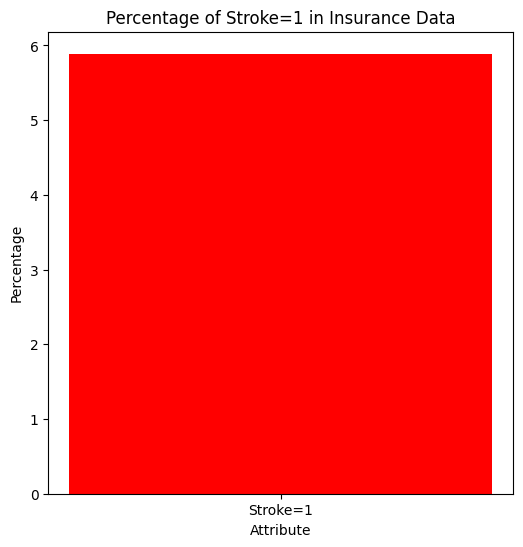

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file CSV
data = pd.read_csv('insurance.csv')

# Lọc nhiễu thuộc tính 'age' là số nguyên và lớn hơn 18
filtered_data = data[(data['age'] > 18) ]
filtered_data = filtered_data.dropna(subset=['bmi'])

# Tính tỷ lệ phần trăm của các trường hợp có giá trị của thuộc tính 'stroke' bằng 1
stroke_percentage = (filtered_data['stroke'] == 1).mean() * 100
print("Tỷ lệ phần trăm của giá trị của thuộc tính 'stroke' bằng 1: {:.2f}%".format(stroke_percentage))

# In ra biểu đồ so sánh
plt.figure(figsize=(6, 6))
plt.bar(['Stroke=1'], [stroke_percentage], color='red')
plt.xlabel('Attribute')
plt.ylabel('Percentage')
plt.title('Percentage of Stroke=1 in Insurance Data')
plt.show()


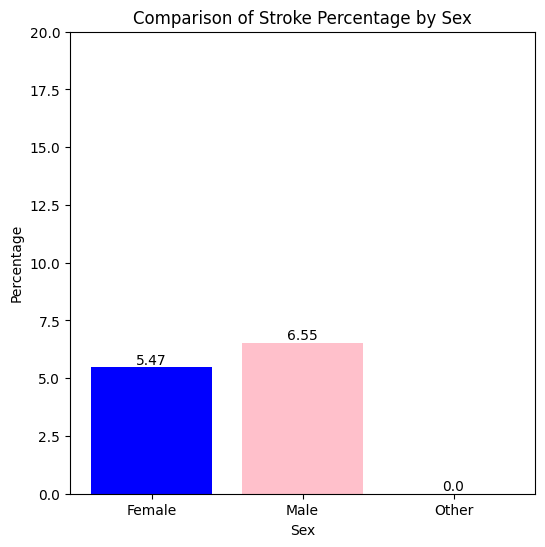

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file CSV
data = pd.read_csv('insurance.csv')

# Lọc nhiễu thuộc tính 'age' là số nguyên và lớn hơn 18
filtered_data = data[(data['age'] > 18)]
filtered_data = filtered_data.dropna(subset=['bmi'])

# Tính tỷ lệ phần trăm của thuộc tính 'stroke' theo từng giá trị của thuộc tính 'sex'
stroke_percentage_by_sex = filtered_data.groupby('sex')['stroke'].mean() * 100

# Vẽ biểu đồ so sánh
plt.figure(figsize=(6, 6))
bars = plt.bar(stroke_percentage_by_sex.index, stroke_percentage_by_sex.values, color=['blue', 'pink'])
plt.xlabel('Sex')
plt.ylabel('Percentage')
plt.title('Comparison of Stroke Percentage by Sex')
plt.ylim(0, 20)

# Thêm giá trị phần trăm trực tiếp lên cột của biểu đồ
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()


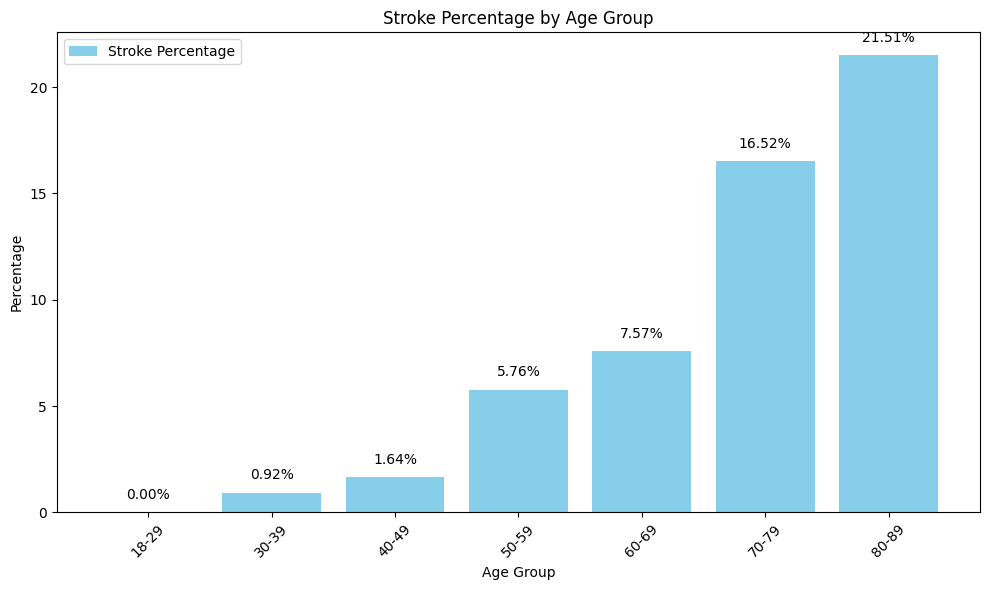

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file CSV
data = pd.read_csv('insurance.csv')

# Định nghĩa các nhóm tuổi
age_bins = [18, 30, 40, 50, 60, 70, 80, 90, 100]
age_labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-100']

# Thêm cột 'age_group' vào dữ liệu
data['age_group'] = pd.cut(data['age'], bins=age_bins, labels=age_labels, right=False)

# Tính số lượng 'stroke' theo từng nhóm tuổi
stroke_count_by_age = data.groupby('age_group')['stroke'].sum()

# Tính tổng số người trong từng nhóm tuổi
total_count_by_age = data['age_group'].value_counts()

# Tính tỷ lệ phần trăm 'stroke' theo từng nhóm tuổi
stroke_percentage_by_age = (stroke_count_by_age / total_count_by_age) * 100

# Vẽ biểu đồ cột đôi và hiển thị tỷ lệ phần trăm
plt.figure(figsize=(10, 6))
plt.bar(stroke_percentage_by_age.index, stroke_percentage_by_age.values, color='skyblue', label='Stroke Percentage')
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.title('Stroke Percentage by Age Group')
plt.xticks(rotation=45)
for i, percentage in enumerate(stroke_percentage_by_age):
    plt.text(i, percentage + 0.5, f'{percentage:.2f}%', ha='center', va='bottom')
plt.legend()
plt.tight_layout()
plt.show()


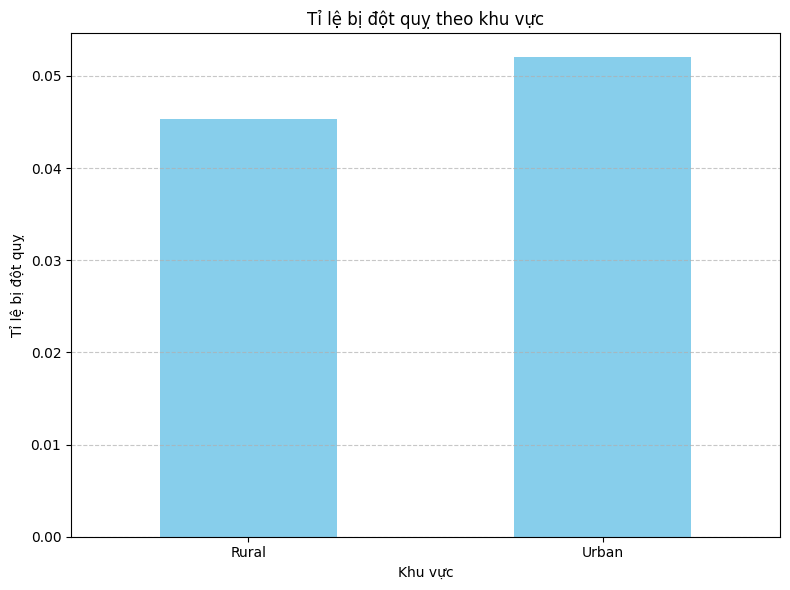

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file CSV
data = pd.read_csv('insurance.csv')

# Tính toán tỉ lệ bị đột quỵ theo từng khu vực
stroke_by_region = data.groupby('region')['stroke'].mean()

# Vẽ biểu đồ cột
plt.figure(figsize=(8, 6))
stroke_by_region.plot(kind='bar', color='skyblue')
plt.title('Tỉ lệ bị đột quỵ theo khu vực')
plt.xlabel('Khu vực')
plt.ylabel('Tỉ lệ bị đột quỵ')
plt.xticks(rotation=0)  # Đặt tên khu vực không xoay
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


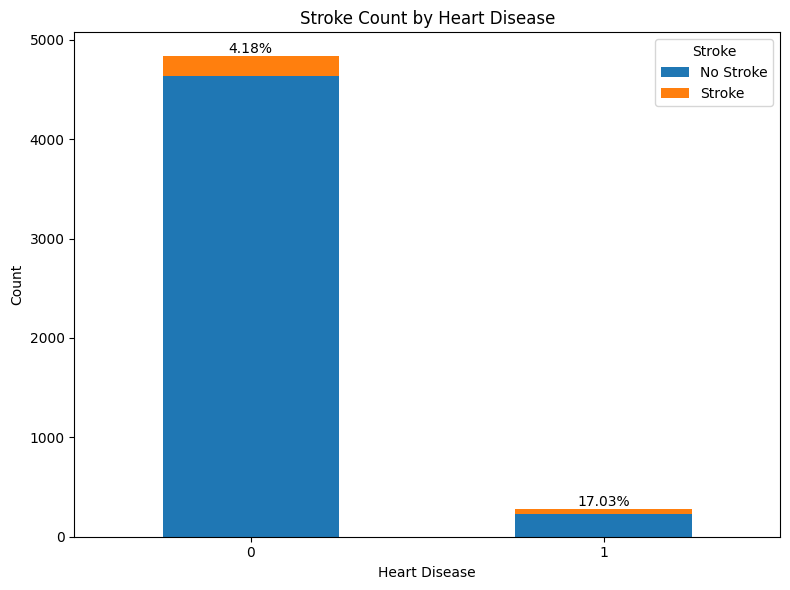

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file CSV
data = pd.read_csv('insurance.csv')

# Lọc nhiễu từ thuộc tính 'heart_disease' và 'stroke'
filtered_data = data.dropna(subset=['heart_disease', 'stroke'])

# Đếm số lượng 'stroke' có giá trị là 1 và 0 theo từng giá trị của 'heart_disease'
stroke_count_by_heart_disease = filtered_data.groupby(['heart_disease', 'stroke']).size().unstack(fill_value=0)

# Vẽ biểu đồ cột đôi
fig, ax = plt.subplots(figsize=(8, 6))
stroke_count_by_heart_disease.plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel('Heart Disease')
ax.set_ylabel('Count')
ax.set_title('Stroke Count by Heart Disease')
ax.legend(title='Stroke', labels=['No Stroke', 'Stroke'])

# Tính tỷ lệ phần trăm của thuộc tính 'stroke' theo từng giá trị của 'heart_disease'
total_stroke_by_heart_disease = stroke_count_by_heart_disease.sum(axis=1)
stroke_percentage_by_heart_disease = (stroke_count_by_heart_disease[1] / total_stroke_by_heart_disease) * 100

# Hiển thị tỷ lệ phần trăm trên biểu đồ
for i, percentage in enumerate(stroke_percentage_by_heart_disease):
    ax.text(i, total_stroke_by_heart_disease[i] + 5, f'{percentage:.2f}%', ha='center', va='bottom')

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


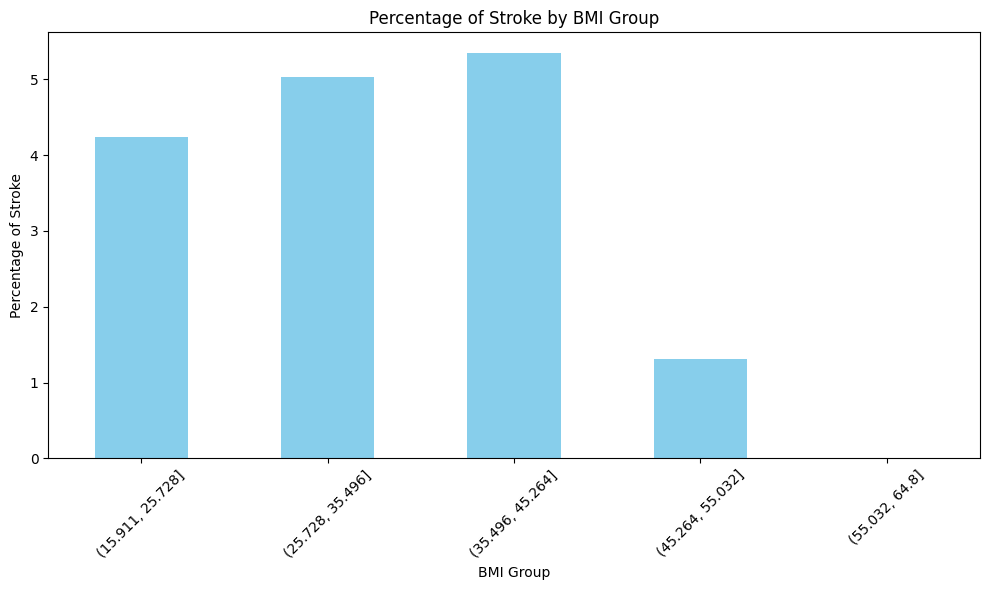

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file CSV
data = pd.read_csv('insurance.csv')

# Xóa các dòng có giá trị 'bmi' bị thiếu
data.dropna(subset=['bmi'], inplace=True)

# Phân nhóm dữ liệu theo giá trị của 'bmi'
data['bmi_group'] = pd.cut(data['bmi'], bins=5)

# Tính tỷ lệ phần trăm 'stroke' theo từng giá trị của 'bmi_group'
stroke_percentage_by_bmi_group = data.groupby('bmi_group')['stroke'].mean() * 100

# Vẽ biểu đồ cột đơn phân bố theo thuộc tính 'bmi_group' và giá trị 'stroke'
plt.figure(figsize=(10, 6))
stroke_percentage_by_bmi_group.plot(kind='bar', color='skyblue')
plt.xlabel('BMI Group')
plt.ylabel('Percentage of Stroke')
plt.title('Percentage of Stroke by BMI Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


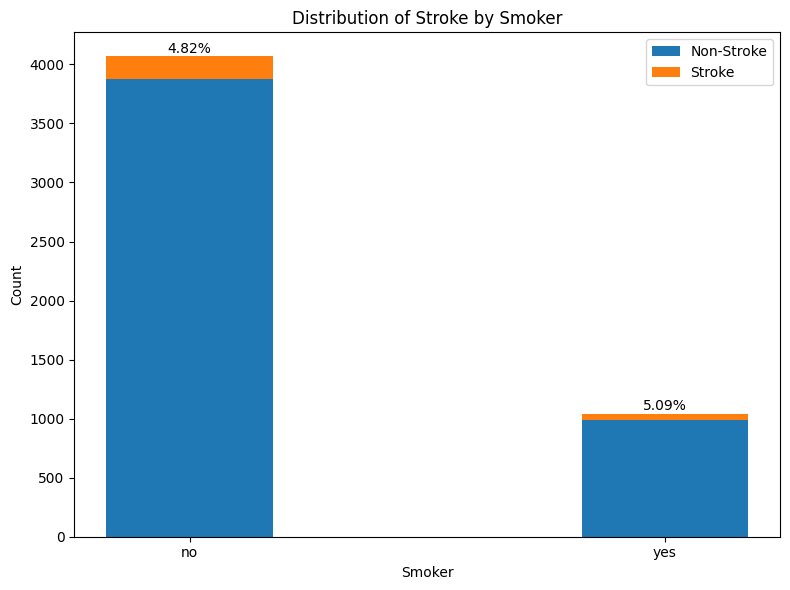

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file CSV
data = pd.read_csv('insurance.csv')

# Tính số lượng 'stroke' và 'non-stroke' theo từng giá trị của 'smoker'
stroke_counts_by_smoker = data.groupby(['smoker', 'stroke']).size().unstack(fill_value=0)

# Tạo biểu đồ cột đôi
fig, ax = plt.subplots(figsize=(8, 6))

x = range(len(stroke_counts_by_smoker))
width = 0.35

rects1 = ax.bar(x, stroke_counts_by_smoker[0], width, label='Non-Stroke')
rects2 = ax.bar(x, stroke_counts_by_smoker[1], width, bottom=stroke_counts_by_smoker[0], label='Stroke')

# Đặt nhãn cho trục x và trục y
ax.set_xlabel('Smoker')
ax.set_ylabel('Count')

# Đặt tiêu đề cho biểu đồ
ax.set_title('Distribution of Stroke by Smoker')

# Đặt các nhãn cho trục x
ax.set_xticks(x)
ax.set_xticklabels(stroke_counts_by_smoker.index)

# Hiển thị chú thích
ax.legend()

# Tính tỷ lệ phần trăm của thuộc tính 'stroke' theo từng giá trị của 'smoker'
total_stroke_by_smoker = stroke_counts_by_smoker.sum(axis=1)
stroke_percentage_by_smoker = (stroke_counts_by_smoker[1] / total_stroke_by_smoker) * 100

# Hiển thị tỷ lệ phần trăm trên biểu đồ
for i, percentage in enumerate(stroke_percentage_by_smoker):
    ax.text(i, total_stroke_by_smoker[i] + 5, f'{percentage:.2f}%', ha='center', va='bottom')

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


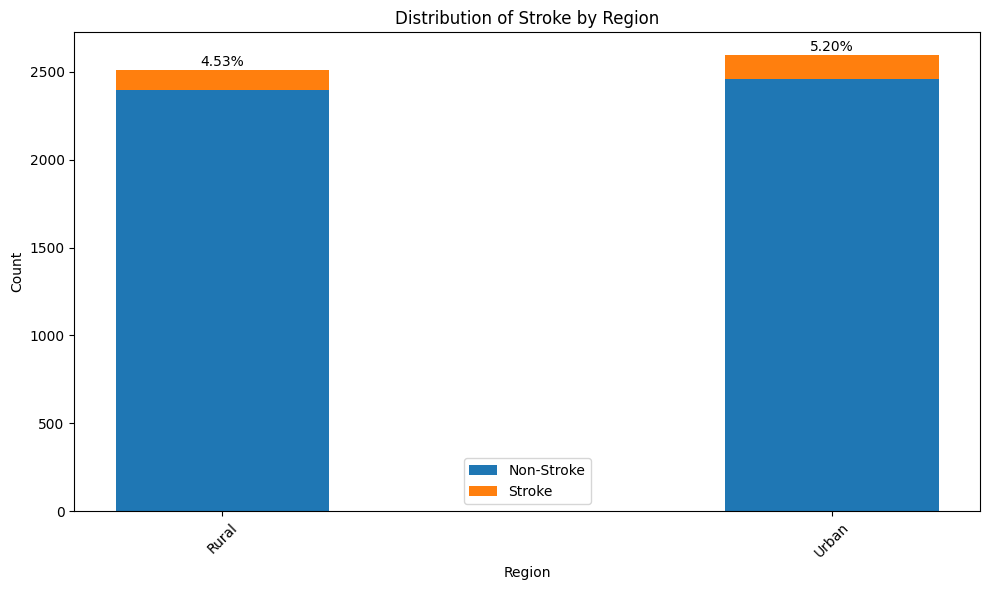

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file CSV
data = pd.read_csv('insurance.csv')

# Lọc nhiễu từ thuộc tính 'region'
filtered_data = data.dropna(subset=['region'])

# Tính số lượng 'stroke' có giá trị là 0 và 1 theo từng giá trị của 'region'
stroke_counts_by_region = filtered_data.groupby(['region', 'stroke']).size().unstack(fill_value=0)

# Tạo biểu đồ cột đôi
fig, ax = plt.subplots(figsize=(10, 6))

x = range(len(stroke_counts_by_region))
width = 0.35

rects1 = ax.bar(x, stroke_counts_by_region[0], width, label='Non-Stroke')
rects2 = ax.bar(x, stroke_counts_by_region[1], width, bottom=stroke_counts_by_region[0], label='Stroke')

# Đặt nhãn cho trục x và trục y
ax.set_xlabel('Region')
ax.set_ylabel('Count')

# Đặt tiêu đề cho biểu đồ
ax.set_title('Distribution of Stroke by Region')

# Đặt các nhãn cho trục x
ax.set_xticks(x)
ax.set_xticklabels(stroke_counts_by_region.index)

# Hiển thị chú thích
ax.legend()

# Tính tỷ lệ phần trăm của 'stroke' theo từng giá trị của 'region'
total_stroke_by_region = stroke_counts_by_region.sum(axis=1)
stroke_percentage_by_region = (stroke_counts_by_region[1] / total_stroke_by_region) * 100

# Hiển thị tỷ lệ phần trăm trên biểu đồ
for i, percentage in enumerate(stroke_percentage_by_region):
    ax.text(i, total_stroke_by_region[i] + 5, f'{percentage:.2f}%', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder

# Đọc dữ liệu từ file CSV
data = pd.read_csv('insurance.csv')

# Chọn các thuộc tính quan trọng
important_features = ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'heart_disease', 'stroke']
data = data[important_features]

# Xử lý thuộc tính categorical
label_encoder_sex = LabelEncoder()
label_encoder_smoker = LabelEncoder()
label_encoder_region = LabelEncoder()

data['sex'] = label_encoder_sex.fit_transform(data['sex'])
data['smoker'] = label_encoder_smoker.fit_transform(data['smoker'])
data['region'] = label_encoder_region.fit_transform(data['region'])

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X = data.drop('stroke', axis=1)
y = data['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Xây dựng mô hình Naive Bayes
model = GaussianNB()
model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# Độ chính xác trên tập kiểm tra
accuracy = (y_pred == y_test).mean()
print("Độ chính xác trên tập kiểm tra: {:.2f}%".format(accuracy * 100))

# Nhập dữ liệu để dự đoán
while True:
    try:
        age = int(input("Age: "))
        if age <= 0:
            raise ValueError("Age must be greater than 0.")

        sex = input("Sex (Male/Female): ")
        if sex.lower() not in ['male', 'female']:
            raise ValueError("Sex must be 'Male' or 'Female'.")

        sex = 1 if sex.lower() == 'male' else 0  # Chuyển đổi giới tính thành số nguyên

        bmi = float(input("BMI: "))
        if bmi <= 0:
            raise ValueError("BMI must be greater than 0.")

        children = int(input("Number of children: "))
        if children < 0:
            raise ValueError("Number of children must be 0 or greater.")

        smoker = input("Smoker (yes/no): ")
        if smoker.lower() not in ['yes', 'no']:
            raise ValueError("Smoker must be 'yes' or 'no'.")

        smoker = 1 if smoker.lower() == 'yes' else 0  # Chuyển đổi 'yes' thành 1 và 'no' thành 0

        region = input("Region (Urban/Rural): ")
        if region not in label_encoder_region.classes_:
            raise ValueError(f"Region must be one of {', '.join(label_encoder_region.classes_)}.")

        region = label_encoder_region.transform([region])[0]

        heart_disease = int(input("Heart Disease (0/1): "))
        if heart_disease not in [0, 1]:
            raise ValueError("Heart Disease must be 0 or 1.")

        break

    except ValueError as e:
        print(f"Giá trị không hợp lệ hoặc nhập sai. Vui lòng nhập lại. {e}")

# Xử lý dữ liệu đầu vào
input_data = pd.DataFrame({'age': [age], 'sex': [sex], 'bmi': [bmi], 'children': [children], 'smoker': [smoker], 'region': [region], 'heart_disease': [heart_disease]})

# Dự đoán khả năng bị đột quỵ
prediction = model.predict(input_data)
print("Dự đoán khả năng bị đột quỵ:", "Chúc mừng bạn đã trúng giải độc đắc: bị đột quỵ :))" if prediction[0] else "Chúc mừng bạn không bị đột quỵ :))")


Độ chính xác trên tập kiểm tra: 91.39%
Age: 20
Sex (Male/Female): Male
BMI: 20
Number of children: 0
Smoker (yes/no): no
Region (Urban/Rural): Urban
Heart Disease (0/1): 0
Dự đoán khả năng bị đột quỵ: Chúc mừng bạn không bị đột quỵ :))
